In [1]:
"""GPT-3 testing"""
import torch
import json
from pathlib import Path
import numpy as np
from src.common.evaluation import METRIC_WEIGHTS

"""CnnDM"""
dataset_name = 'cnndm_chatgpt'
set_name = 'test'
generation_methods=['top_p_sampling']
models = ['gpt-3.5-turbo']
metrics = ['rouge1', 'rouge2', 'rougeLsum']
"""commongen"""
# dataset_name = 'commongen'
# set_name = 'val'
# generation_methods=['beam_search', 'diverse_beam_search']
# models = ['t5_common_gen']
# metrics = ['bleu', 'cider']
"""wmt18"""
# dataset_name = 'wmt18'
# set_name = 'test'
# generation_methods=['beam_search', 'diverse_beam_search']
# models = ['opus_mt']
# metrics = ['bleu']



with open(f"./data/prepared/{dataset_name}/{set_name}/dataset.jsonl", "r") as f:
    data = [json.loads(line) for line in f]
for item in data:
    item['candidates'] = [c for c in item['candidates'] if c['model'] in models]
    item['candidates'] = [c for c in item['candidates'] if c['generation_method'] in generation_methods]
    for candidate in item['candidates']:
        candidate['scores'] = {
            metric: candidate['scores'][metric] for metric in metrics
        }
backbone = "microsoft/deberta-v3-large"
# backbone = "roberta-large"
checkpoint_path = Path(f"./outputs/crosscompare/{backbone}/test_{dataset_name}_PairReranker_full_comparison/")
predictions = torch.load(checkpoint_path / "predictions.pt")
labels = torch.load(checkpoint_path / "labels.pt")

scores = np.array([[list(c['scores'].values()) for c in item['candidates']] for item in data])
# readjust the weight of the labels so that it's the same with scores
for i, metric in enumerate(metrics):
    labels[:, :, i] = labels[:, :, i] / METRIC_WEIGHTS[metric]
if np.abs((scores - labels)).mean() < 1e-5:
    print("dataset score consistent with PairReranker labels")
else:
    print(np.abs((scores - labels)).mean())
# get the ranks
ranks = np.flip(np.argsort(scores, axis=1), axis=1)
values = np.arange(ranks.shape[1]).reshape(1, -1, 1).repeat(ranks.shape[0], axis=0).repeat(ranks.shape[2], axis=2)
np.put_along_axis(ranks, ranks.copy(), values, axis=1)

dataset score consistent with PairReranker labels


In [108]:
SR_backbone = "microsoft/deberta-v3-large"
# SR_backbone = "roberta-large"
SR_checkpoint_path = Path(f"./outputs/scr/{SR_backbone}/train_{dataset_name}_SummaReranker/")
SR_predictions = torch.load(SR_checkpoint_path / "predictions.pt")
SR_labels = torch.load(SR_checkpoint_path / "labels.pt")
# readjust the weight of the labels so that it's the same with scores
for i, metric in enumerate(metrics):
    SR_labels[:, :, i] = SR_labels[:, :, i] / METRIC_WEIGHTS[metric]
if np.abs((scores - SR_labels)).mean() < 1e-5:
    print("dataset score consistent with SummaReranker labels")
else:
    print(np.abs((scores - SR_labels)).mean())

dataset score consistent with SummaReranker labels


In [109]:
full_cmp_results = predictions[0]
_predictions = full_cmp_results.sum(axis=-1) - full_cmp_results.sum(axis=1)
_labels = labels.mean(-1)
sorted_idx = np.argsort(_labels, axis=1)
sorted_idx = sorted_idx[:, ::-1]
_labels = _labels[np.arange(_labels.shape[0])[:, None], sorted_idx]
_predictions = _predictions[np.arange(_predictions.shape[0])[:, None], sorted_idx]
_SR_predictions = SR_predictions[np.arange(SR_predictions.shape[0])[:, None], sorted_idx]
# _full_cmp_results = full_cmp_results[np.arange(full_cmp_results.shape[0])[:, None, None], sorted_idx[:, :, None], sorted_idx[:, None, :]]
ref_cmp_results = _labels[:, :, None] - _labels[:, None, :]
_full_cmp_results = _predictions[:, :, None] - _predictions[:, None, :]
SR_cmp_results = _SR_predictions[:, :, None] - _SR_predictions[:, None, :]
acc = _full_cmp_results * ref_cmp_results > 0
SR_acc = SR_cmp_results * ref_cmp_results > 0
print(acc.mean())
print(SR_acc.mean())

0.590178899526158
0.5891118847306837


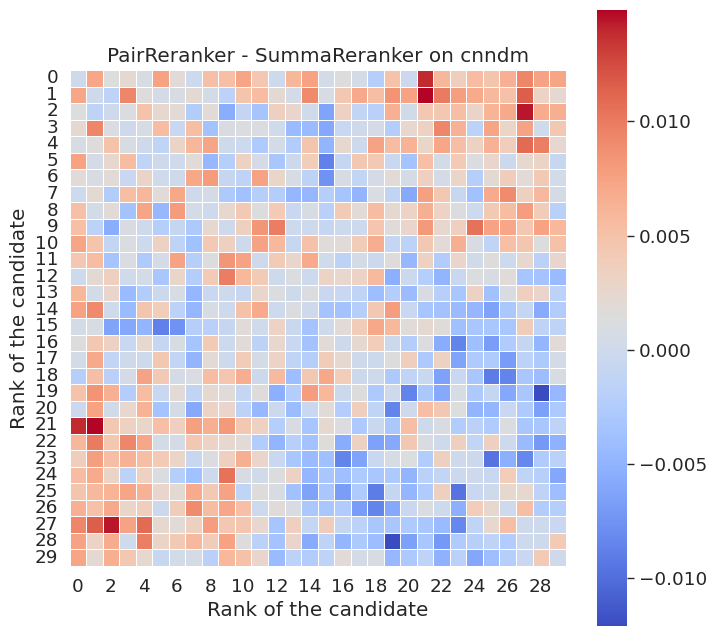

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
sns.set_theme(font='Times New Roman', style='whitegrid')
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ax1 = sns.heatmap(acc.mean(0), fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, ax=axes[0])
# ax2 = sns.heatmap(SR_acc.mean(0), fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, ax=axes[1])
plt.figure(figsize=(8, 8))
sns.heatmap(acc.mean(0) - SR_acc.mean(0), fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.xlabel("Rank of the candidate")
plt.ylabel("Rank of the candidate")
plt.title(f"PairReranker - SummaReranker on {dataset_name}")
plt.show()

In [4]:
# Pairreranker full comparison
full_cmp_results = predictions[0]
# full_cmp_results = torch.tanh(torch.tensor(full_cmp_results)).numpy()
# best_idx = full_cmp_results.sum(axis=-1).argmax(-1) # pre-position comparison
# best_idx = full_cmp_results.sum(axis=1).argmin(-1) # post-position comparison
best_idx = (full_cmp_results.sum(axis=-1) - full_cmp_results.sum(axis=1)).argmax(-1) # max_logits comparison
# best_idx = ((full_cmp_results > 0).sum(axis=-1) + (full_cmp_results < 0).sum(axis=-2)).argmax(-1) # most wins
best_scores = scores[np.arange(len(best_idx)), best_idx]
best_ranks = ranks[np.arange(len(best_idx)), best_idx]
mean_scores = best_scores.mean(axis=0)
mean_ranks = best_ranks.mean(axis=0)
print("Pairreranker full comparison results")
for metric, mean_score, mean_rank in zip(metrics, mean_scores, mean_ranks):
    print(metric, mean_score, mean_rank)

Pairreranker full comparison results
rouge1 0.39949070039128065 2.6584856396866843
rouge2 0.1628534271390145 3.0033942558746736
rougeLsum 0.3603176936854047 2.762053959965187


In [3]:
# SummaReranker
SR_best_idx = SR_predictions.argmax(-1)
SR_best_scores = scores[np.arange(len(SR_best_idx)), SR_best_idx]
SR_best_ranks = ranks[np.arange(len(SR_best_idx)), SR_best_idx]
SR_mean_scores = SR_best_scores.mean(axis=0)
SR_mean_ranks = SR_best_ranks.mean(axis=0)
print("SummaReranker Comparison results")
for metric, mean_score, mean_rank in zip(metrics, SR_mean_scores, SR_mean_ranks):
    print(metric, mean_score, mean_rank)

SummaReranker Comparison results
rouge1 0.4160939904698082 4.784
rouge2 0.1810002765226232 5.13
rougeLsum 0.378026947145419 4.841
